# Day 3 : Deep Reinforcement Learning

In [1]:
import os
os.chdir('Day3/')

In [2]:
!pip install --upgrade pip
!pip install -r requirements.txt

In [3]:
%load_ext autoreload
%autoreload 2

import numpy as np
import time
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

## Content

- OpenAI Gym -- Cartpole
- Deep Q-Network
- Exercise

## OpenAI Gym -- Cartpole

Gym is a toolkit for developing and comparing reinforcement learning algorithms. The gym library is a collection of test problems — **environments** — that you can use to work out your reinforcement learning algorithms. These environments have a shared interface, allowing you to write general algorithms.

Cartpole - known also as an Inverted Pendulum - is one of the available gyms. It consists of a pendulum with a center of gravity above its pivot point. It’s unstable, but can be controlled by moving the pivot point under the center of mass. The goal is to keep the cartpole balanced by applying appropriate forces to a pivot point.

<img src="Day3/CartPole.png" width=aut hight=auto align=center >

In the ilustration we observe:
- The violet square indicates a pivot point
- Red and green arrows show possible horizontal forces that can be applied to a pivot point

The goal of the problem is the follwing:

> A pole is attached by an un-actuated joint to a cart, which moves along a frictionless track. The system is controlled by applying a force of +1 or -1 to the cart. The pendulum starts upright, and the goal is to prevent it from falling over. A reward of +1 is provided for every timestep that the pole remains upright. The episode ends when the pole is more than 15 degrees from vertical, or the cart moves more than 2.4 units from the center.

We instatiate the OpenAI Cartpole enviromet with the following command.

In [4]:
import gym
env = gym.make('CartPole-v1')
env.reset()

array([-0.03883184, -0.02298981, -0.02505773, -0.04402502])

Calling the `reset()` method will return the first observation (more on this below).

Gyms are based on a **Markov Chain** model as ilustrated:

<img src="Day3/MarkovChain.png" width=aut hight=auto align=center >

At each time step $t$ the **agent** (i.e. our algorithm) chooses an action based on the previous state and observed reward. The action space is obtain by the following command.

In [5]:
env.action_space

Discrete(2)

In this case there are only two possible actions, either push the cart to the left or to the right. 

|Num   |Action                 |
|------|-----------------------|
|0	   |Push cart to the left  |
|1	   |Push cart to the right |

We can sample a random action as follows:

In [6]:
action = env.action_space.sample()
print(action)

1


Once an action is selected, we ask the enviroment to execute the given action. This is done with the following command:

In [7]:
observation, reward, done, info = env.step(action)
print('Observation: {} \n\
Reward: {} \n\
Done: {} \n\
Info: {}'.format(observation, reward, done, info))

Observation: [-0.03929163  0.17248233 -0.02593823 -0.34450739] 
Reward: 1.0 
Done: False 
Info: {}


The environment’s `step` function returns four values. These are:

- `observation` **(object)**: an environment-specific object representing your observation of the environment. In this case it is an array of four floats given by:

|Num   |Observation           | Min  | Max  |
|------|----------------------|------|------|   
|0     |Cart Position         | -4.8 | 4.8  |
|1	   |Cart Velocity         | -Inf | Inf  |
|2	   |Pole Angle            | -24  | 24   |
|3	   |Pole Velocity At Tip  | -Inf | Inf  |

- `reward` **(float)**: amount of reward achieved by the previous action. A reward of +1 is provided for every timestep that the pole remains upright.
- `done` **(boolean)**: whether it’s time to reset the environment again. This can be triggered by one of the following:
  1. Pole Angle is more than 12 degrees
  2. Cart Position is more than 2.4 (center of the cart reaches the edge of the display)
  3. Episode length is greater than 200
- `info` **(dict)**: diagnostic information useful for debugging. 

**Solved Requirements**: Problem is considered solved when the average reward is greater than or equal to 195.0 over 100 consecutive trials.

Let us play $10$ episodes (sleeping $1$ seconds between iterations) selecting random actions at each timestep to demostrate the Markov Chain loop. The visualisation will open in a new window. The enviroment has a method `render()` that we can use to visualize a given state. 

In [9]:
env = gym.make('CartPole-v1')
for i_episode in range(10):
    time.sleep(1)
    observation = env.reset()
    for t in range(300):
        env.render()
        action = env.action_space.sample()
        observation, reward, done, info = env.step(action)
        if done:
            print("Episode finished after {} timesteps".format(t+1))
            break
env.close()

Episode finished after 14 timesteps
Episode finished after 13 timesteps
Episode finished after 21 timesteps
Episode finished after 20 timesteps
Episode finished after 26 timesteps
Episode finished after 12 timesteps
Episode finished after 12 timesteps
Episode finished after 47 timesteps
Episode finished after 27 timesteps
Episode finished after 21 timesteps


## Deep Q-Network

Let us now implement an agent for solving the Cartpole problem using a Deep Q-Network. We start by loading `tensorflow` and our strategy `DQN`.

In [63]:
import tensorflow as tf
from Day3.util import DQN

We initialize the gym enviroment.

In [64]:
env.close()
env = gym.make('CartPole-v1')

And register the shape of the observation and action spaces.

In [65]:
observation_space = env.observation_space.shape[0]
action_space = env.action_space.n

In order to initialize the `DQN` strategy, we need to provide a pre-compiled Keras neural network such that:
- The input layer has as many neurons as parameters of the observation space.
- The output layer has as many neurons as possile actions.

Recall that this neural network will try to predict the Q-value (quality) of a (state, action) pair.

In [66]:
model = tf.keras.models.Sequential([
    tf.keras.layers.InputLayer(input_shape=(observation_space,)),
    tf.keras.layers.Dense(50, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(25, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(action_space, activation='linear')
])

In [67]:
model.compile(optimizer=tf.keras.optimizers.Adam(),
              loss=tf.losses.MeanSquaredError(),
              metrics=['accuracy'])

We now initialize our stratey:

In [68]:
dqn_strategy = DQN(model)

A `DQN` object has the following methods:
- `action(state)`: given the value of a state, it outputs the proposed action to play next.
- `remember(state, action, reward, next_state, done)`: stores the given values on a memory buffer.
- `experience_replay`: trains the network with randomly sampled (state, action) pairs from the memory buffer.

This `DQN` strategy balances between exploration and exploration using an epsilon-greedy strategy, where the value of epsilon starts at $1.0$ and decays over time until it reaches $0.01$.

Let us now run the loop for $100$ iterations while registering the output values for later inspection. It takes some time.

In [69]:
# List to log scores.
score_logger = []

In [ ]:
for i in range(100):
    # Reset the enviroment
    state = env.reset()
    state = np.reshape(state, [1, observation_space])
    
    # Run an episode until we reach a terminal state.
    step = 0
    while True:
        step += 1
        env.render()
        
        #Select action to be played
        action = dqn_strategy.action(state)
        
        #Play given action
        state_next, reward, terminal, info = env.step(action)
        
        #Observe reward, if state is terminal reward is negative since it means that we have failed
        reward = reward if not terminal else -reward
        
        #Add tuple to memory buffer and update state
        state_next = np.reshape(state_next, [1, observation_space])
        dqn_strategy.remember(state, action, reward, state_next, terminal)
        state = state_next
        
        #Experience Replay 
        dqn_strategy.experience_replay()
              
        #Break loop and record output values if arrive to terminal state
        if terminal:
            score_logger.append(step)
            print("Run: " + str(i) + ", exploration: " + str(dqn_strategy.exploration_rate) + ", score: " + str(step))
            break

Finally, let's plot the scores. 

Text(0.5, 1.0, 'Results')

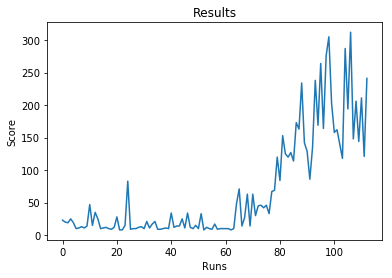

In [71]:
plt.plot(score_logger)
plt.xlabel('Runs')
plt.ylabel('Score')
plt.title('Results')

And let's check if we solved the problem, recall that solving means average score of 195.0 over 100 consecutive runs.

In [74]:
average_score = []
for i in range(len(score_logger)-100):
    average_score.append(np.mean(score_logger[i:i+100]))

Text(0.5, 1.0, 'Results')

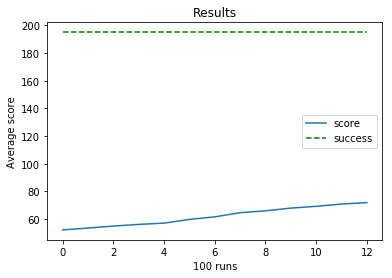

In [79]:
plt.plot(average_score, label='score')
plt.plot([0, len(average_score)-1], [195.0, 195.0,], 'g--', label='success')
plt.xlabel('100 runs')
plt.ylabel('Average score')
plt.legend(loc='best')
plt.title('Results')

## Exercise

Play with the above code to see if you manage to solve the problem.